In [108]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import math

In [109]:
#header creation and directory paths

usage_dir = "task_usage/"
job_dir = "job_events/"

task_usage_header = ['start_time','end_time','job_id','task_index','machine_id', 'mean_cpu_usage',
                     'canon_memory_usage', 'assign_memory_usage', 'unmapped_cache', 'total_cache', 
                     'max_mem', 'mean_io', 'mean_space', 'max_cpu', 'max_io', 'cpi', 'mai', 'sample',
                     'agg_type', 'sample_cpu_usage']

job_header = ['timestamp','missing_info', 'job_id', 'event_type', 'user_name', 'scheduling_class',
              'job_name','logical_job_name']

In [110]:
#read csv - drop unused columns

final_df = pd.DataFrame()

# 3 files used for each category
for i in range(3):
    file_str = str(i).zfill(5)
    usage_df = pd.read_csv(usage_dir +"part-"+file_str+"-of-00500.csv.gz",header=None)
    usage_df.columns = task_usage_header
#     print(usage_df)
    job_df = pd.read_csv(job_dir +"part-"+file_str+"-of-00500.csv.gz",header=None)
    job_df.columns = job_header
#     print(job_df)
    job_df.drop(['missing_info','user_name', 'scheduling_class',
                  'job_name','logical_job_name'], axis =1,inplace=True)

    usage_df.drop(['task_index','machine_id','canon_memory_usage', 'assign_memory_usage', 'unmapped_cache', 'total_cache', 
                         'max_mem', 'mean_io', 'mean_space', 'max_cpu', 'max_io', 'cpi', 'mai', 'sample',
                         'agg_type', 'sample_cpu_usage'], axis =1,inplace=True)

    #merge to filter jobs with valid life - SCHEDULE to FINISH

    new_jobdf = pd.merge(job_df[(job_df['event_type'] == 1)],job_df[ (job_df['event_type'] == 4)], on = "job_id")
    new_jobdf.drop(['event_type_x',  'event_type_y'], axis =1,inplace=True)
    new_jobdf['life_time'] = new_jobdf['timestamp_y'] -  new_jobdf['timestamp_x']
    new_jobdf.drop(['timestamp_x',  'timestamp_y'], axis =1,inplace=True)
    #new_jobdf
    #merge to get cpu usage of jobs with valid lifetime

    n_jobdf = pd.merge(usage_df,new_jobdf, on = "job_id")
    n_jobdf['start_time'] = (n_jobdf['start_time']/1000000)
    n_jobdf['end_time'] = (n_jobdf['end_time']/1000000)
    n_jobdf['life_time'] = (n_jobdf['life_time']/1000000)
#     print(n_jobdf)
    #n_jobdf
    # arrage cpu uses by jobs- add parallel cpu uses of all tasks of a jobs during a time cycle
    final_df = final_df.append(n_jobdf.groupby(['job_id','start_time','end_time']).sum())



      start_time  end_time      job_id  mean_cpu_usage    life_time
0          600.0     900.0  6245463804        0.000050  3452.681356
1          900.0    1200.0  6245463804        0.000050  3452.681356
2         1200.0    1500.0  6245463804        0.000050  3452.681356
3         1500.0    1800.0  6245463804        0.000052  3452.681356
4         1800.0    2100.0  6245463804        0.000045  3452.681356
5         2100.0    2400.0  6245463804        0.000045  3452.681356
6         2400.0    2700.0  6245463804        0.000048  3452.681356
7         2700.0    3000.0  6245463804        0.000053  3452.681356
8         3000.0    3300.0  6245463804        0.001850  3452.681356
9         3300.0    3442.0  6245463804        0.000791  3452.681356
10        3442.0    3456.0  6245463804        0.000588  3452.681356
11        3456.0    3457.0  6245463804        0.000000  3452.681356
12         600.0     900.0  6248941479        0.000280  4219.709190
13         900.0    1200.0  6248941479        0.

      start_time  end_time      job_id  mean_cpu_usage    life_time
0        10655.0   10669.0  6252244272        0.000000    37.396258
1        10669.0   10675.0  6252244272        0.005577    37.396258
2        10675.0   10690.0  6252244272        0.000125    37.396258
3        10690.0   10691.0  6252244272        0.000000    37.396258
4        10661.0   10675.0  6252283218        0.030300    31.246001
5        10675.0   10683.0  6252283218        0.000188    31.246001
6        10683.0   10684.0  6252283218        0.000000    31.246001
7        10666.0   10736.0  6252283461        0.000000  1520.501147
8        10736.0   10800.0  6252283461        0.003712  1520.501147
9        10800.0   10984.0  6252283461        0.003223  1520.501147
10       10984.0   11100.0  6252283461        0.003304  1520.501147
11       11100.0   11400.0  6252283461        0.003693  1520.501147
12       11400.0   11700.0  6252283461        0.014070  1520.501147
13       11700.0   12000.0  6252283461        0.

In [ ]:
#normalising the mean cpu usage - y axis

for i in final_df.index.get_level_values(0).unique():
    minn = final_df.loc[i]['mean_cpu_usage'].min()
    maxx = final_df.loc[i]['mean_cpu_usage'].max() 
    final_df.loc[i]['mean_cpu_usage'] = (final_df.loc[i]['mean_cpu_usage'] - minn)/(maxx-minn)
    
final_df

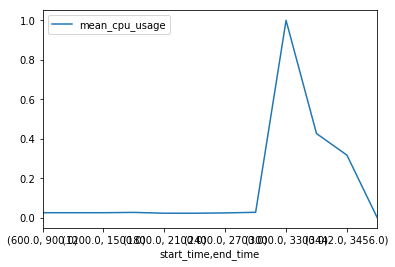

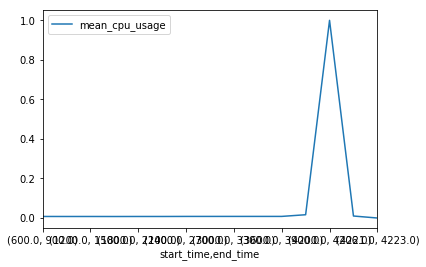

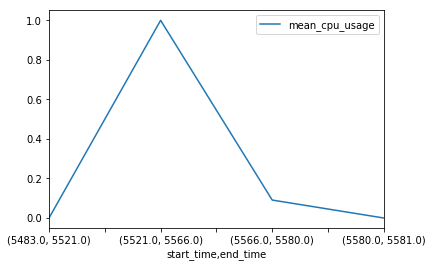

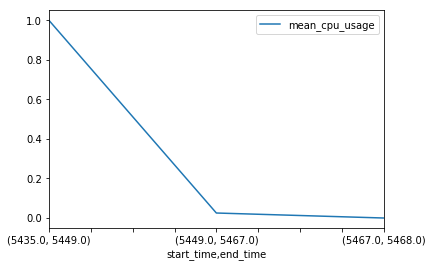

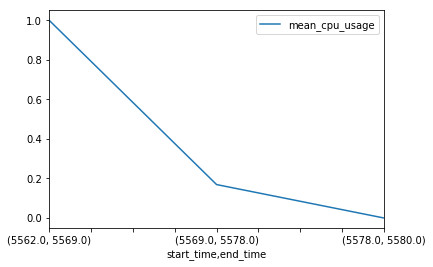

In [74]:
#5 plots of random jobs and their cpu usages

final_df.loc[6245463804]['mean_cpu_usage'].plot(legend=True)
plt.show()

final_df.loc[6248941479]['mean_cpu_usage'].plot(legend=True)
plt.show()

final_df.loc[6252015953]['mean_cpu_usage'].plot(legend=True)
plt.show()

final_df.loc[6252014624]['mean_cpu_usage'].plot(legend=True)
plt.show()

final_df.loc[6252018909]['mean_cpu_usage'].plot(legend=True)
plt.show()

In [112]:
#function to calculate values in each bin of each job's cpu uasge distribution

def calc_point(x1,y1,x2,y2,point):
    y=(point-x1)*(y2-y1)/(x2-x1)+y1
    if math.isnan(y):
        return -1000
    return y
def calculateValues(dataframe):
    my_points=[]
    start_index = 0
    next_index=1
    row0 = dataframe.iloc[start_index]
    row1 = dataframe.iloc[next_index]
    point = row0.end_time
    x1= row0.end_time
    x2= row1.end_time
    y1= row0.mean_cpu_usage
    y2= row1.mean_cpu_usage
    end_point = dataframe.iloc[dataframe.shape[0]-1].end_time
    my_points.append(y1)
#     print(point)
#     print(end_point)
    bin_size = (end_point-point)/100
#     print(bin_size)
    for i in range(100):
        point = point + bin_size
        if point > x2:
            start_index += 1
            next_index += 1
            if next_index >= dataframe.shape[0]:
                return my_points
            row0 = dataframe.iloc[start_index]
            row1 = dataframe.iloc[next_index]
            point = row0.end_time
            x1= row0.end_time
            x2= row1.end_time
            y1= row0.mean_cpu_usage
            y2= row1.mean_cpu_usage
#         print(point)
        val = calc_point(x1,y1,x2,y2,point)
        if val == -1000:
            return [-1000]
        my_points.append(val)
#     print(len(my_points))
    my_points.append(0)
    return my_points

In [113]:
#divide each lifetime into 100 bins
#get vector of all job's common usage distribution

dummy = final_df.reset_index(level='start_time')
dummy.reset_index(level='end_time',inplace=True)

job_ids = dummy.index.get_level_values(0).unique()
count = len(job_ids)
# job_ids
prev_point = [0]*102
for job_id in job_ids:
    #print(job_id)
    small_df = dummy[dummy.index == job_id]
    if small_df.shape[0] > 10:
        ponts = calculateValues(small_df)
#         print(ponts)
        if ponts[0] != -1000:
            prev_point = [x + y for x, y in zip(prev_point, ponts)]
#         print(len(prev_point))
#     print(small_df)
#final_df.index.unique().shape[0]
newList = [x / count for x in prev_point]

/Users/banani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


In [114]:
#vector of mean of all the distribution - 100 values
newList

[0.0004955327392218717,
 0.00044250354164144097,
 0.00035914136541622755,
 0.00026088615820734365,
 0.000241211445517944,
 0.00027489893649036684,
 0.0003017357528131885,
 0.00032864520347471133,
 0.00035781493941386454,
 0.0003833306580797964,
 0.00040809674355396904,
 0.00043279564753249467,
 0.0004629032915880431,
 0.0004902254957187371,
 0.0005139806339395952,
 0.000534249961699133,
 0.00018957659888246635,
 0.00019017052547412407,
 0.00019979736819737535,
 0.0002251319628388896,
 0.00024769155840007046,
 0.0006386311139242244,
 0.0010296004480945826,
 0.0011300856876563631,
 0.00032669822286944306,
 0.000357825516006112,
 0.0003895832304747123,
 0.00041880067590164194,
 0.0002478035748379144,
 0.0002623509758057867,
 0.0002765729891209858,
 0.000291252982599171,
 0.00030577007090385475,
 0.0003200052607340423,
 0.000321329012919981,
 0.0003321420151760211,
 0.00034316590963079954,
 0.00035883609631148035,
 0.0003731931435677048,
 0.00038803196021053944,
 0.00040289413571912994,
 0

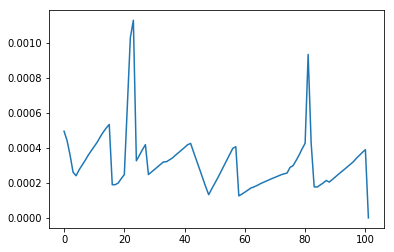

In [115]:
#plot graph of mean usage distribution

plt.plot(newList)
plt.show()

In [116]:
#K_S test to see if this vector comes from a normal distribution

#print(newList)
val =stats.kstest(newList, 'norm')
val

KstestResult(statistic=0.5, pvalue=0.0)